In [1]:
import os
os.environ['XLA_FLAGS'] = "--xla_force_host_platform_device_count=3"
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

import numpy as np
import multiprocessing

from src.CRMagTraj.solver import TrajectorySolver
from src.CRMagTraj.field import IGRFField, ConstField
from src.CRMagTraj.particle import Antiproton
from src.CRMagTraj.utils import cartesian_to_spherical

jax.config.update("jax_enable_x64", True)

In [2]:
antiproton = Antiproton() # energy in eV
field = IGRFField("IGRF14.shc", 2011, 4, 28, 5)
# field = ConstField(0.0, 0.0, -50e-6)  # Tesla

solver = TrajectorySolver(field, antiproton, 100.0, 10*6371.2*1000.0, 6791.1*1000, 10*6371.2*1000)
# solver = TrajectorySolver(field, antiproton, 100.0, 3000*1000.0, 7371.2*1000, 10*6371.2*1000)

Loading IGRF field data from: IGRF14.shc


In [3]:
x0 = jnp.array([6791.2*1000, 2.6986455558, -2.2580122296])
v0 = jnp.array([0.5797897120000002, 3.4275823241999994])

energy=1534816624.7210636 # eV
# note that the jacobian is computed in cartesian coordinates
jacobian = solver.jacobian(x0, v0, energy, "spherical")

In [4]:
jacobian_np = np.array(jax.device_get(jacobian))

In [5]:
print(jacobian_np)

[[[ 5.35381048e+00  1.25086073e+01 -2.38354816e+01 -4.46507816e-02
    2.85817696e-02 -4.31741695e-01]]

 [[ 4.56219742e+00 -7.63338620e+01  1.01329693e+02  1.20384982e-01
    4.58652884e-02  5.80260863e-01]]

 [[ 2.92346019e+00  1.60159353e+01 -1.31069997e+01 -9.38215130e-03
    2.17607104e-02 -6.71834050e-02]]

 [[-1.45263515e+01  7.46703297e+02 -9.45797907e+02 -1.15405946e+00
   -2.91142792e-02 -6.71741629e+00]]

 [[ 1.20485987e+01 -6.42797868e+02  8.17506320e+02  9.38944187e-01
    2.79150464e-01  4.51944028e+00]]

 [[ 1.86246210e+01  6.23823056e+02 -1.01381126e+03 -1.32748759e+00
   -5.35129866e-01 -7.19734238e+00]]]


In [6]:
# calculate the jacobian determinant
jacobian_det = jnp.linalg.det(jnp.reshape(jacobian, (6, 6)))
print("Jacobian determinant:", jacobian_det)

Jacobian determinant: 0.9999999999474136


In [7]:
sol = solver.single_run(x0, v0, energy, coordinate_system="spherical", saveat=True)

0.00%
2.00%
4.00%
6.00%
8.00%
10.00%
12.00%
14.00%
16.00%
18.00%
20.00%
22.00%
24.00%
26.00%
28.00%
30.00%
32.00%
34.00%
36.00%
38.00%
40.00%
42.00%
44.00%
46.00%
48.00%
50.00%
52.00%
54.00%
56.00%
58.00%
60.00%
62.00%
64.00%
66.00%
68.00%
70.00%
72.00%
74.00%
76.00%
78.00%
80.00%
82.00%
84.00%
86.00%
88.00%
90.00%
92.00%
94.00%
96.00%
98.00%
100.00%


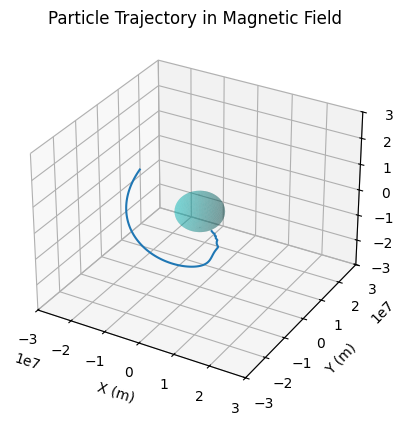

In [9]:
pos = sol[0:3]
x = sol[0] * jnp.cos(sol[1]) * jnp.sin(sol[2])
y = sol[0] * jnp.sin(sol[1]) * jnp.sin(sol[2])
z = sol[0] * jnp.cos(sol[2])

# plot a 3D trajectory
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, rasterized=True)

# create a sphere of radius 6378 for reference
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
sphere_x = 6378000 * np.outer(np.cos(u), np.sin(v))
sphere_y = 6378000 * np.outer(np.sin(u), np.sin(v))
sphere_z = 6378000 * np.outer(np.ones(np.size(u)), np.cos(v))

ax.plot_surface(sphere_x, sphere_y, sphere_z, color='c', alpha=0.3)

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('Particle Trajectory in Magnetic Field')
# set range for all axes
ax.set_xlim([-30000000, 30000000])
ax.set_ylim([-30000000, 30000000])
ax.set_zlim([-30000000, 30000000])

plt.show()